## Fake News Classifier by Sharique

### Step 1: Setup

In [2]:
import os
import re
import string
import joblib
import numpy as np
import pandas as pd

from collections import Counter
from pathlib import Path

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# NLP utils
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup  # <-- to remove HTML tags safely

# Ensure NLTK data is present (safe to call multiple times)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

RANDOM_STATE = 42

### Step 2: Config

Fake shape: (23481, 5)  | True shape: (21417, 5)
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


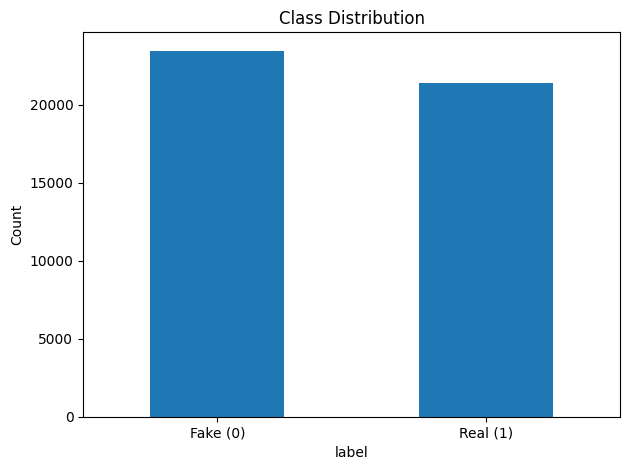

In [3]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")
fake["label"] = 0  # 0 = Fake
true["label"] = 1  # 1 = Real

df = pd.concat([fake, true], axis=0).reset_index(drop=True)
print("Fake shape:", fake.shape, " | True shape:", true.shape)
print(df.head())

# Class balance
ax = df["label"].value_counts().sort_index().plot(kind="bar")
ax.set_xticklabels(["Fake (0)", "Real (1)"], rotation=0)
ax.set_title("Class Distribution")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

### Step3: Text Processing

In [4]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
url_re = re.compile(r"http\S+|www\S+|https\S+")

def clean_text(txt: str) -> str:
    if not isinstance(txt, str):
        return ""
    
    txt = txt.lower()
    txt = BeautifulSoup(txt, "html.parser").get_text()   # remove HTML tags
    txt = url_re.sub("", txt)                            # remove URLs
    txt = re.sub(r"\d+", " ", txt)                       # remove numbers
    txt = re.sub(r"[^a-z\s]", " ", txt)                  # remove non-letters
    txt = re.sub(r"\s+", " ", txt).strip()               # collapse spaces
    
    words = [w for w in txt.split() if w not in stop_words and len(w) > 2]
    words = [lemmatizer.lemmatize(w) for w in words]
    
    return " ".join(words)

### Step 4: Train / Test Split & Vectorization (TF-IDF)

In [5]:
if "combined" not in df.columns:  # short guard
    df["combined"] = (df["title"].fillna("") + " " + df["text"].fillna("")).apply(clean_text)

# Drop any rows where combined text is empty after cleaning
df = df[df["combined"].str.strip() != ""].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    df["combined"], df["label"],
    test_size=0.2, random_state=RANDOM_STATE, stratify=df["label"]
)

vectorizer = TfidfVectorizer(max_df=0.7, min_df=3, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("Train TF-IDF shape:", X_train_tfidf.shape, "| Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (35911, 599373) | Test TF-IDF shape: (8978, 599373)


### Step 5: Baseline Models (For comparasion)

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=None),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "Linear SVM": LinearSVC(random_state=RANDOM_STATE),
}

def evaluate(model_name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, preds, average="weighted", zero_division=0)
    print(f"\n=== {model_name} ===")
    print(classification_report(y_te, preds, digits=4))
    return {"Model": model_name, "Accuracy": acc, "Precision": pr, "Recall": rc, "F1": f1}, preds, model

results = []
pred_store = {}
trained_models = {}

for name, mdl in models.items():
    metrics, preds, fitted_model = evaluate(name, mdl, X_train_tfidf, y_train, X_test_tfidf, y_test)
    results.append(metrics)
    pred_store[name] = preds
    trained_models[name] = fitted_model   # <-- keep the fitted model

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)

print(results_df)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9884    0.9817    0.9850      4695
           1     0.9801    0.9874    0.9837      4283

    accuracy                         0.9844      8978
   macro avg     0.9842    0.9845    0.9844      8978
weighted avg     0.9844    0.9844    0.9844      8978


=== Multinomial NB ===
              precision    recall  f1-score   support

           0     0.9569    0.9589    0.9579      4695
           1     0.9548    0.9526    0.9537      4283

    accuracy                         0.9559      8978
   macro avg     0.9558    0.9557    0.9558      8978
weighted avg     0.9559    0.9559    0.9559      8978


=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9942    0.9883    0.9912      4695
           1     0.9872    0.9937    0.9905      4283

    accuracy                         0.9909      8978
   macro avg     0.9907    0.9910    0.9908      897

In [7]:
# Pick the best one
best_name = results_df.iloc[0]["Model"]
best_model = trained_models[best_name]

print("Best (by F1):", best_name)

Best (by F1): Gradient Boosting


#### Confusion Matrix for best model

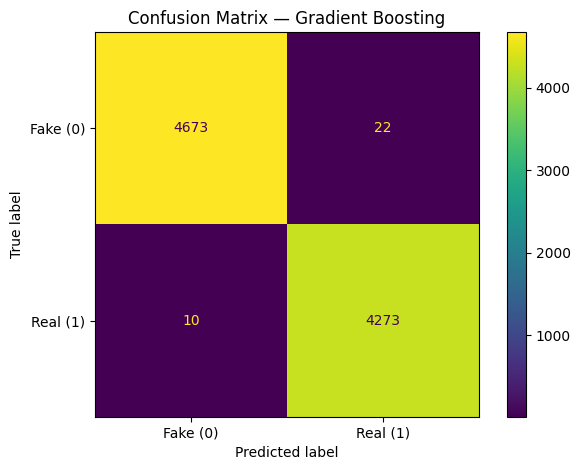

In [8]:
best_preds = pred_store[best_name]
cm = confusion_matrix(y_test, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake (0)", "Real (1)"])
disp.plot(xticks_rotation=0)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()

### Step 6:  Save Artifacts (Vectorizer + Best Model)

In [9]:
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(best_model, "best_model.joblib")

['best_model.joblib']

### Step 7: Quick Intereference (for testing)

In [10]:
# A tiny helper to test arbitrary snippets right inside the notebook.
def predict_snippet(text: str):
    vec = joblib.load("tfidf_vectorizer.joblib")
    mdl = joblib.load("best_model.joblib")
    X = vec.transform([text])
    pred = mdl.predict(X)[0]
    proba = None
    if hasattr(mdl, "predict_proba"):
        proba = mdl.predict_proba(X)[0, pred]
    elif hasattr(mdl, "decision_function"):
        d = mdl.decision_function(X)[0]
        proba = 1 / (1 + np.exp(-d))
        if pred == 0:
            proba = 1 - proba
    return int(pred), (float(proba) if proba is not None else None)

# Example:
# predict_snippet("Government announces new infrastructure plan to boost economy.")

### Step 8: Insights

In [11]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Separate texts by label
fake_texts = df[df["label"] == 0]["text"]
true_texts = df[df["label"] == 1]["text"]

# Tokenize (very simple split on space, since we already cleaned)
fake_words = " ".join(fake_texts).split()
true_words = " ".join(true_texts).split()

fake_counts = Counter(fake_words)
true_counts = Counter(true_words)

#### - Top words in fake vs. true news

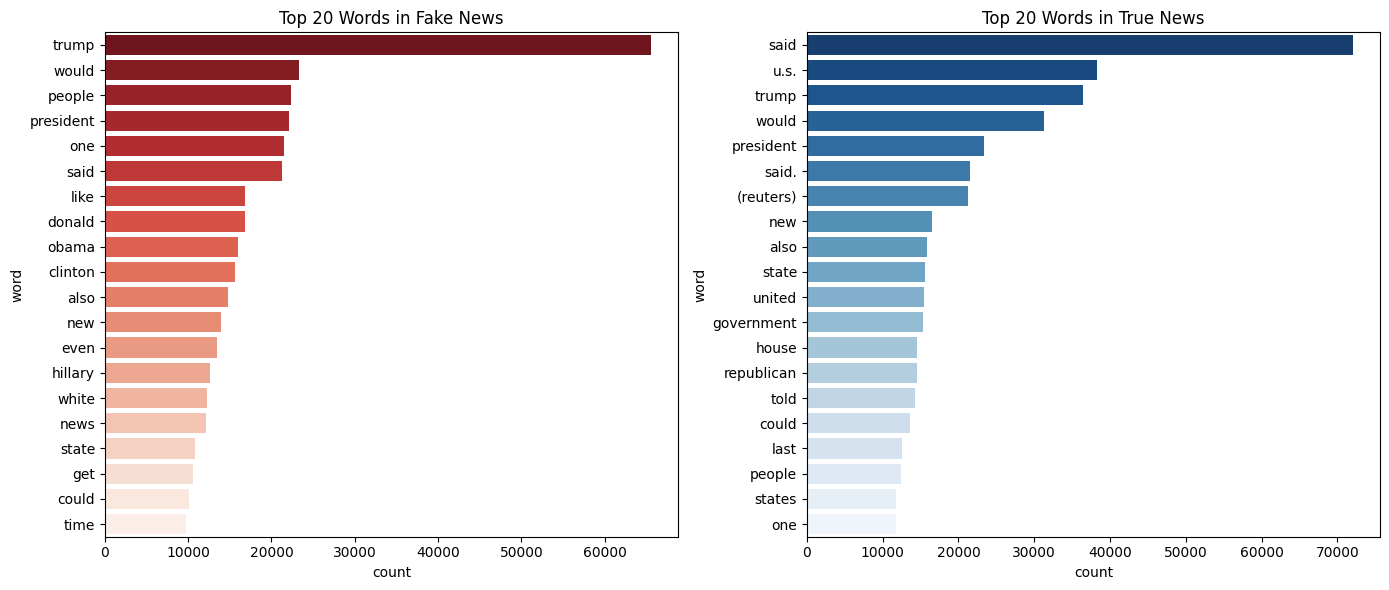

In [12]:
stop_words = set(stopwords.words("english"))

# Add your own extra stopwords
custom_words = {"is", "am", "are", "the"}  
stop_words.update(custom_words)

def get_word_counts(series):
    all_words = []
    for text in series.dropna():
        # lower + split
        words = text.lower().split()
        # remove stopwords + single letters
        words = [w for w in words if w not in stop_words and len(w) > 2]
        all_words.extend(words)
    return Counter(all_words)

# Recompute counts with stopwords removed
fake_counts = get_word_counts(fake["text"])   # or "combined" column if you merged
true_counts = get_word_counts(true["text"])

# Get top 20 most common words in each class
top_fake = fake_counts.most_common(20)
top_true = true_counts.most_common(20)

# print("Top words in Fake News:", top_fake)
# print("Top words in True News:", top_true)

# Plotting (same as before)
fake_df = pd.DataFrame(top_fake, columns=["word","count"])
true_df = pd.DataFrame(top_true, columns=["word","count"])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x="count", y="word", data=fake_df, ax=axes[0],
            hue="word", palette="Reds_r", legend=False)
axes[0].set_title("Top 20 Words in Fake News")

sns.barplot(x="count", y="word", data=true_df, ax=axes[1],
            hue="word", palette="Blues_r", legend=False)
axes[1].set_title("Top 20 Words in True News")

plt.tight_layout()
plt.show()

#### - Swear words in Real vs Fake news

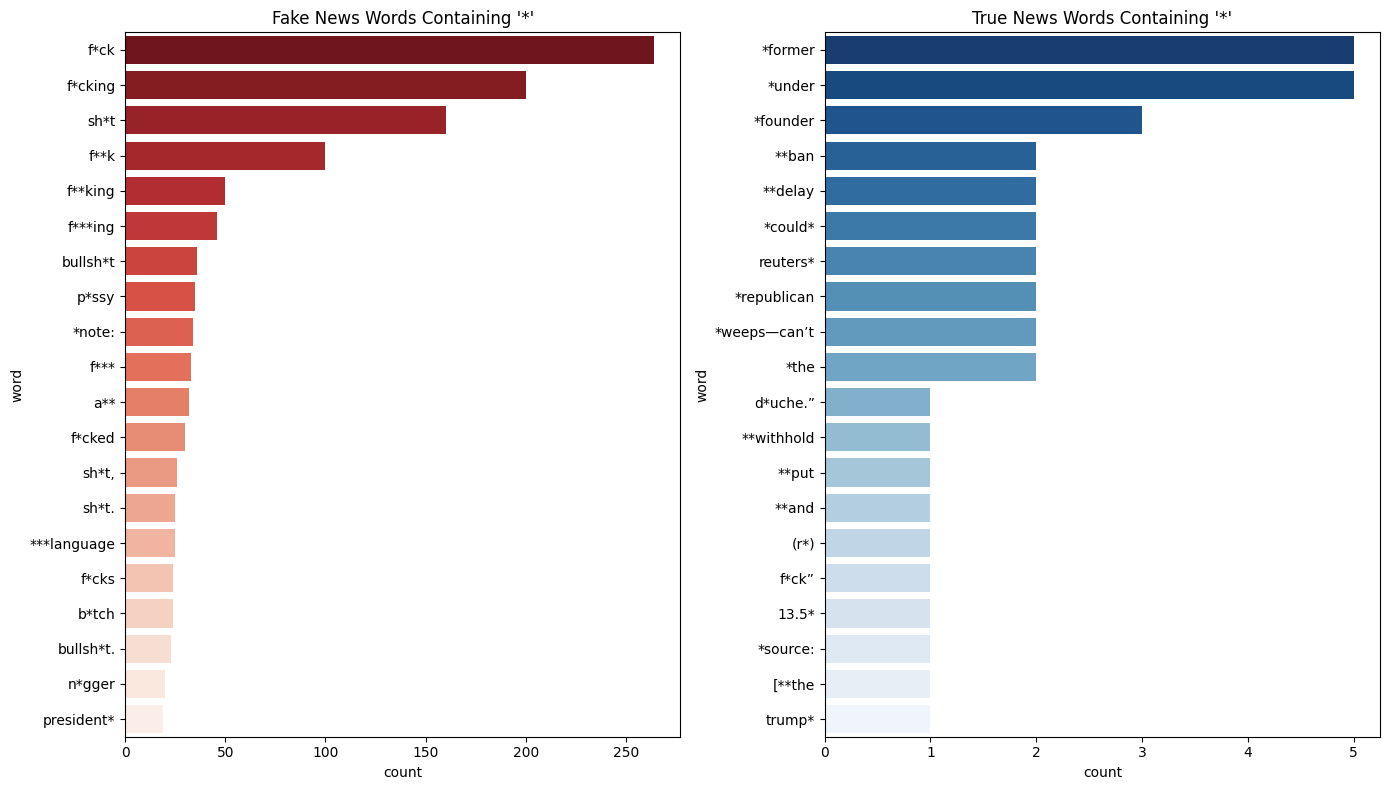

In [13]:
fake_star = {w:c for w,c in fake_counts.items() if "*" in w}
true_star = {w:c for w,c in true_counts.items() if "*" in w}

fake_star_df = pd.DataFrame(sorted(fake_star.items(), key=lambda x: -x[1]), columns=["word","count"])
true_star_df = pd.DataFrame(sorted(true_star.items(), key=lambda x: -x[1]), columns=["word","count"])

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.barplot(x="count", y="word", data=fake_star_df.head(20), ax=axes[0], hue="word", palette="Reds_r", legend=False)
axes[0].set_title("Fake News Words Containing '*'")

sns.barplot(x="count", y="word", data=true_star_df.head(20), ax=axes[1], hue="word", palette="Blues_r", legend=False)
axes[1].set_title("True News Words Containing '*'")

plt.tight_layout()
plt.show()

#### - Word clouds

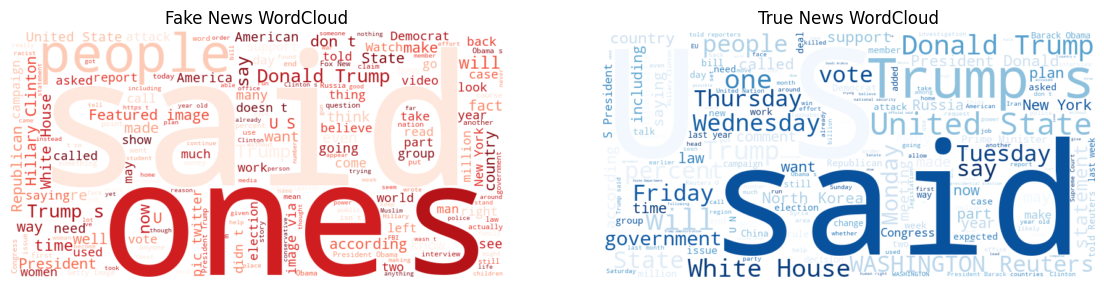

In [14]:
fake_cloud = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(" ".join(fake_words))
true_cloud = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(" ".join(true_words))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(fake_cloud, interpolation="bilinear")
plt.axis("off")
plt.title("Fake News WordCloud")

plt.subplot(1,2,2)
plt.imshow(true_cloud, interpolation="bilinear")
plt.axis("off")
plt.title("True News WordCloud")
plt.show()

#### - Article Length Distribution

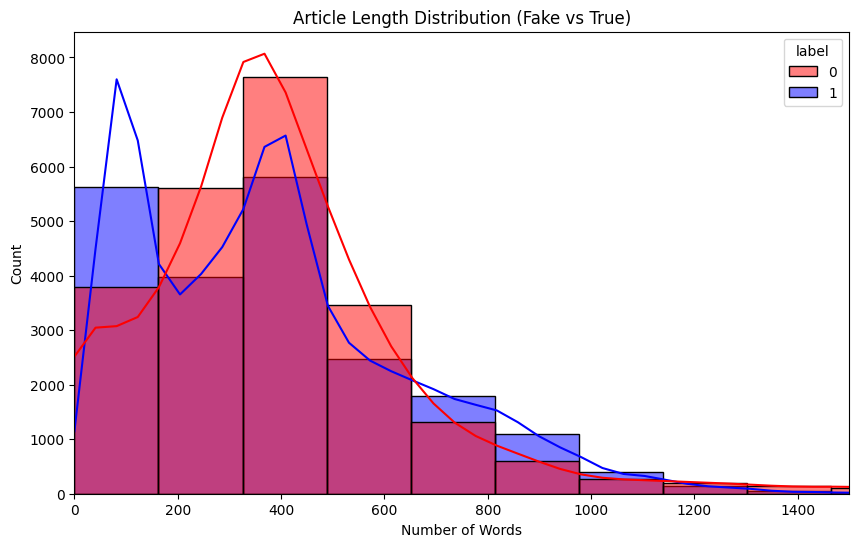

In [22]:
# Compare how long Fake vs True news articles typically are.

df["length"] = df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(data=df, x="length", hue="label", bins=50, palette=["red","blue"], kde=True)

plt.title("Article Length Distribution (Fake vs True)")
plt.xlabel("Number of Words")
plt.ylabel("Count")

# Limit x-axis range
plt.xlim(0, 1500)

plt.show()